### Importação das bibliotecas

In [1]:
import copy
import sys
from subprocess import getoutput as gop

import matplotlib.pyplot as plt
import mne
import numpy as np
from mne.time_frequency import psd_welch as psdw

### Leitura do arquivo de dados

In [2]:
def loadData(arquivo):
    arqOpen = open(f'data_10hz/{arquivo}')
    fileLimitTime = 0
    
    for _ in range(6):
        next(arqOpen)
    
    eeg = list()
    person = list()
    for row in arqOpen:
        columns = row.split(',')

        if columns:
            columns = columns[:7]
                    
            if(columns[0] == '0'):
                if(len(eeg) == 256):
                    fileLimitTime +=1
                    for k in eeg:
                        person.append(list(map(lambda i : float(i), k[1:])))
                eeg = list()
            
            eeg.append(columns)

    return [np.array(person).T, fileLimitTime]

###  Prepara o raw, onde contém os dados da base importados, que posteriormente serão transformados do domínio do tempo para o dominio da frequência

In [3]:
def prepareRaw(data):
    info = mne.create_info(ch_names=['eeg'] * 6, sfreq=256, ch_types=['eeg'] * 6)
    raw = mne.io.RawArray(data, info)

    for _ in range(5):
        raw.filter(l_freq=5, h_freq=50)

    return raw

### Escala um valor de 0 a 100.

In [4]:
def scaleValue(max, min):
    return ((min*100)/max)

### Separa as frequências (alpha, beta, gama, teta), e posteriormente verifica se alhpa é a maior de todas, acha a segunda maior e tira a diferença e retorna o valor escalado. Serve pra achar os tempos em que ocorre o chamado ritmo alpha.

In [5]:
def findAlphaTime(raw, tmin, window):
    faixas = list()
    
    alpha = psdw(raw, tmin=tmin, tmax=tmin+window, fmin=8,  fmax=12,  verbose=False)[0]   
    theta = psdw(raw, tmin=tmin, tmax=tmin+window, fmin=5,  fmax=7,   verbose=False)[0]
    beta  = psdw(raw, tmin=tmin, tmax=tmin+window, fmin=12, fmax=30,  verbose=False)[0]
    gamma = psdw(raw, tmin=tmin, tmax=tmin+window, fmin=25, fmax=100, verbose=False)[0]
    
    faixas.append(np.average(alpha))
    faixas.append(np.average(theta))
    faixas.append(np.average(beta))
    faixas.append(np.average(gamma))
    
    indexMaiorFaixa = np.argmax(np.array(faixas))
    
    if (indexMaiorFaixa == 0):
        indexSegMaiorFaixa = np.argmax(np.array(faixas[1:]))+1
        print(f'{tmin}: {scaleValue(faixas[indexMaiorFaixa], faixas[indexSegMaiorFaixa])}')

###  Plota os tempos encontrados anteriormente, mas somente alguns são selecionados. A janela de tempo está com apenas 3 segundos.

In [6]:
def plotWindowTime(raw, tmin, window, fmax=30):
    psds, freqs = psdw(raw, tmin=tmin, tmax=tmin+window, fmax=fmax)
    psd_Average = np.average(psds, axis=0) ** 2
    plt.plot(freqs, psd_Average)
    plt.show()

(6, 204288)
Creating RawArray with float64 data, n_channels=6, n_times=204288
    Range : 0 ... 204287 =      0.000 ...   797.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 423 samples (1.652 sec)



<ipython-input-3-3e7d4c4754be>:5: RuntimeWarning: Channel names are not unique, found duplicates for: {'eeg'}. Applying running numbers for duplicates.
  ch_types=['eeg'] * 6)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 423 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge:

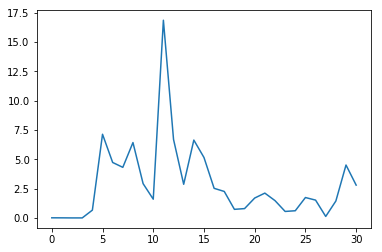

Effective window size : 1.000 (s)


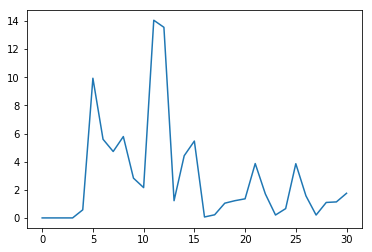

Effective window size : 1.000 (s)


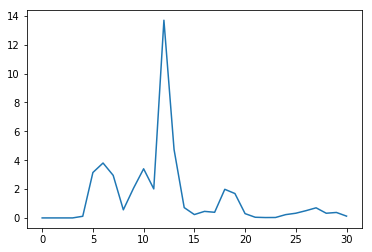

Effective window size : 1.000 (s)


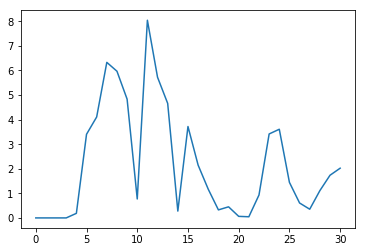

Effective window size : 1.000 (s)


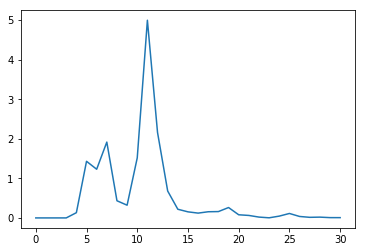

Effective window size : 1.000 (s)


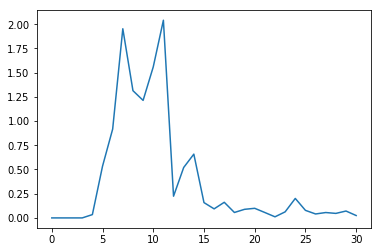

(6, 130304)
Creating RawArray with float64 data, n_channels=6, n_times=130304
    Range : 0 ... 130303 =      0.000 ...   508.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 423 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB s

<ipython-input-3-3e7d4c4754be>:5: RuntimeWarning: Channel names are not unique, found duplicates for: {'eeg'}. Applying running numbers for duplicates.
  ch_types=['eeg'] * 6)


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 423 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 423 samp

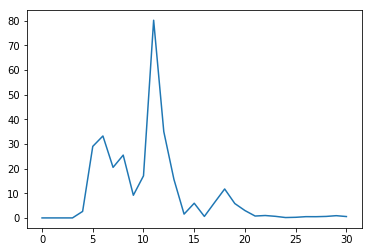

Effective window size : 1.000 (s)


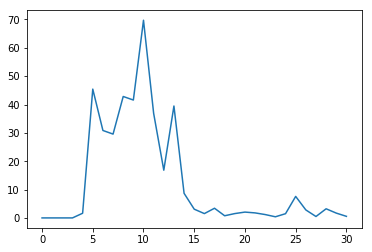

Effective window size : 1.000 (s)


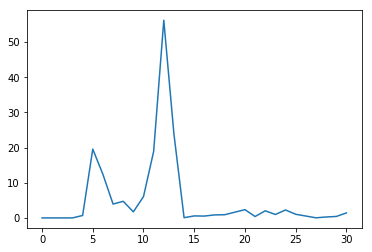

Effective window size : 1.000 (s)


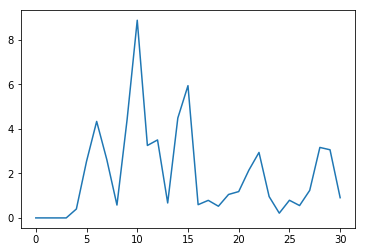

Effective window size : 1.000 (s)


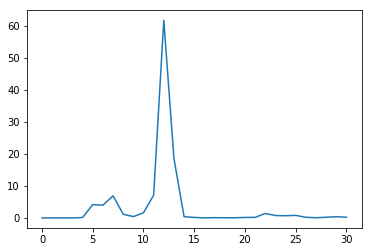

Effective window size : 1.000 (s)


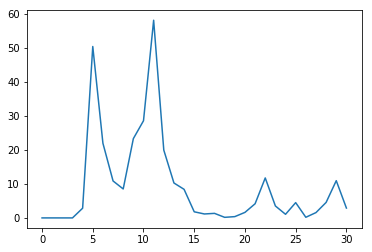

(6, 59904)
Creating RawArray with float64 data, n_channels=6, n_times=59904
    Range : 0 ... 59903 =      0.000 ...   233.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 423 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stop

<ipython-input-3-3e7d4c4754be>:5: RuntimeWarning: Channel names are not unique, found duplicates for: {'eeg'}. Applying running numbers for duplicates.
  ch_types=['eeg'] * 6)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 423 samples (1.652 sec)

Effective window size : 1.000 (s)


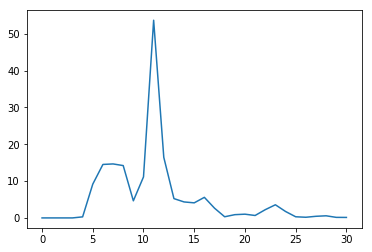

Effective window size : 1.000 (s)


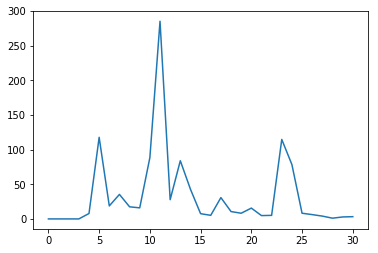

Effective window size : 1.000 (s)


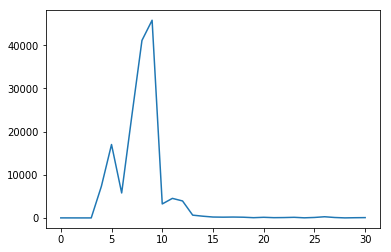

Effective window size : 1.000 (s)


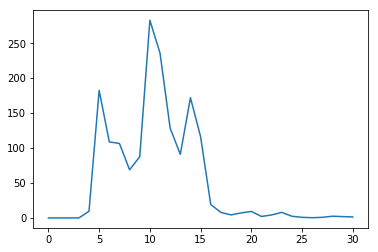

Effective window size : 1.000 (s)


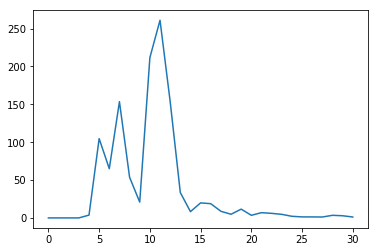

Effective window size : 1.000 (s)


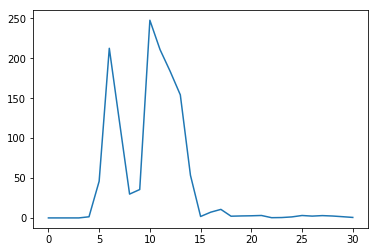

In [7]:
arquivos = gop('ls data_10hz').split('\n')
times = [[95, 96, 234, 367, 597, 786],
        [39, 46, 110, 130, 280, 363],
        [103, 114, 136, 154, 171, 185]]
window = 3

for arqPos, arq in enumerate(arquivos):
    data, fileLimitTime = loadData(arq)
    print(data.shape)
    raw = prepareRaw(data)

    for i in times[arqPos]:
        plotWindowTime(raw, i, window)